# **Train the output layer of MobileNet-v2**

**Train the output layer of MobileNet-v2 for mask detection**

### **Start by mounting the drive**

**Mounting the Drive allows the notebook to access the dataset folder. You can see all the files in your Drive this way, but no one else can see them because a new VM is loaded each time. **

In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Load the required modules and data**





In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as trn
from torch.autograd import Variable as V
import torch.nn.functional as F

from matplotlib import rcParams
rcParams['axes.grid'] = False

In [ ]:
# data_path = 'gdrive/My Drive/CV-FinalProject/dataset/'
data_path = 'gdrive/My Drive/mask_detection/dataset/'
training = pd.read_csv((data_path + 'training/training.csv'), index_col=0)
validation = pd.read_csv((data_path + 'validation/validation.csv'), index_col=0)
validation.shape

(200, 2)

### **Preprocess Images**

In [ ]:
def preprocess(image_fname):
    center_crop = trn.Compose([
        trn.Resize((256, 256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_input = Image.open(image_fname)
    return V(center_crop(img_input).unsqueeze(0))

In [ ]:
def batch(df, path, batch_size):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  random_ind = np.random.choice(len(df), size=batch_size, replace=False)
  label_batch = df['labels'].iloc[random_ind].to_numpy()

  input_batch = preprocess((path + df['files'].iloc[random_ind[0]]))
  for i in df['files'].iloc[random_ind[1:]]:
      input_batch = torch.cat((input_batch, preprocess((path + i))), 0)
  
  with torch.no_grad():
    input_batch = input_batch.cuda()
    label_batch = V(torch.from_numpy(label_batch).cuda())

  return input_batch, label_batch

### **Define model**

**First we are going to load the pretrained model and freeze all the weights. Then, we replace the fully connected output layer with a new layer that will train.**

In [ ]:
#load model
model = torchvision.models.googlenet(pretrained=True)
#print(model)

**freeze network layers**
https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088

In [ ]:
for param in model.parameters():
    param.requires_grad = False

**replace output layer**
https://discuss.pytorch.org/t/how-to-replace-a-layer-or-module-in-a-pretrained-network/60068

**`in_features` is the same as before. `out_features` becomes 2 because we only have two classes (mask and no mask). It was 1000 because there 1000 object classes in ImageNet which the model was trained on.** 





In [ ]:
model.fc = nn.Linear(in_features=1024, out_features=2, bias=True)
#print(model)
# model.AuxLogits.fc = nn.Linear(768, 2)
# model.fc = nn.Linear(2048, 2)
# print(model)

**Send to cuda and check that `requires_grad` for my new layer is True**

In [ ]:
#send to GPU
assert torch.cuda.is_available()
model.cuda()
# model.classifier[-1].weight

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

## **Train the model**

**Helper function that performs the forward pass, backpropagation, and then gradient update steps for a single batch.**

In [ ]:
def train_step(batch_size=32):
  
  model.train()

  input_batch, label_batch = batch(training, (data_path + 'training/'), batch_size)
  output_batch = model(input_batch)

  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return loss.data, error_rate.data

**Evaluation function**

In [ ]:
def val(input_batch, label_batch):
  
  model.eval()
  
  output_batch = model(input_batch)

  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.data, error_rate.data

**Load the validation data**

In [ ]:
input_val, label_val = batch(validation, (data_path + 'validation/'), len(validation))

**Finally, let's train, and also plot loss and error rate as a function of iteration.**

In [ ]:
def test():
  data_path = 'gdrive/My Drive/mask_detection/dataset/'
  test = pd.read_csv((data_path + 'validation/validation.csv'), index_col=0)
  cor = 0
  err = 0
  for i in range(test.shape[0]):
    filename = test.iloc[i, 0]
    label = test.iloc[i, 1]

    img=preprocess('gdrive/My Drive/mask_detection/dataset/validation/' + filename)
    img=img.type(torch.cuda.FloatTensor)
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)
    rlt = predicted[0]
    if(rlt == label):
      cor += 1.0
    else:
      err += 1.0
  AP = cor / (cor + err)
  return AP

Step     0: Obtained a best validation AP of 0.515000. train loss 0.696063
Step    50: Obtained a best validation AP of 0.535000. train loss 0.207306
Step   100: Obtained a best validation AP of 0.530000. train loss 0.105221
Step   150: Obtained a best validation AP of 0.510000. train loss 0.110814
Step   200: Obtained a best validation AP of 0.525000. train loss 0.070856
Step   250: Obtained a best validation AP of 0.510000. train loss 0.116329
Step   300: Obtained a best validation AP of 0.530000. train loss 0.115192
Step   350: Obtained a best validation AP of 0.515000. train loss 0.051505
Step   400: Obtained a best validation AP of 0.530000. train loss 0.060804
Step   450: Obtained a best validation AP of 0.500000. train loss 0.027068


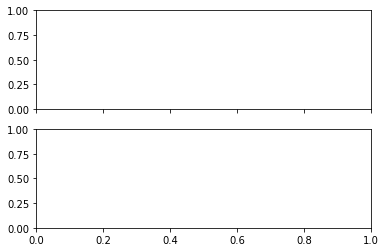

In [ ]:
# info = []
# fig, ax = plt.subplots(2, 1, sharex=True)
# num_steps = 500
# num_steps_per_val = 50
# best_val_err = 1.0
# for step in range(num_steps):
#   train_loss, train_err = train_step()
#   if step % num_steps_per_val == 0:
#     val_loss, val_err = val(input_val, label_val)
#     if val_err < best_val_err:
#       best_val_err = val_err
#       # print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
#       print('Step {:5d}: Obtained a best validation error of {:.6f}. loss of {:.6f}'.format(step, best_val_err, val_loss))
#     else:
#       print('Step {:5d}: Obtained a best validation error of {:.6f}. loss of {:.6f}'.format(step, best_val_err, val_loss))
#     info.append([step, train_loss, val_loss, train_err, val_err])
#     x, y11, y12, y21, y22 = zip(*info)
#     ax[0].plot(x, y11, x, y12)
#     ax[0].legend(['Train loss', 'Val loss'])
#     ax[1].plot(x, y21, x, y22)
#     ax[1].legend(['Train err', 'Val err'])
#     ax[1].set_ylim([0.0, 0.25])

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 500
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    AP = test()
    print('Step {:5d}: Obtained a best validation AP of {:.6f}. train loss {:.6f}'.format(step, AP, train_loss))

**Save the learned model weights**

In [ ]:
# torch.save(model.state_dict(), 'gdrive/My Drive/mask_detection/googlnet_masknet.pth')
torch.save(model, 'gdrive/My Drive/mask_detection/googlenet_masknet.pth') 